### Pretrained 모델 with 머신러닝
- 마지막 출력층 (출력노드의수 = 1000) 바로 직전의 층 (avg_pool)의 출력값을
- 각 이미지의 feature 정보로 사용
- avg_pool층이 출력하는 값의 수 = 2048
- 각 이미지의 특성을 2048의 변수로 표현
- 2048개의 feature 정보를 사용하여 분류 알고리즘(classifier) 적용

In [14]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from matplotlib.pyplot import imshow
import math
import numpy as np
from glob import glob

In [15]:
IMG_CHANNELS = 3
IMG_ROWS = 299
IMG_COLS = 299
CLASSES = 2

In [7]:
# 파일 경로에 지정, 이미지 로드
mountain_files = glob('../../../data/s_3/imgs/data_mw/man/*jpg')
sea_files = glob('../../../data/s_3/imgs/data_mw/woman/*jpg')

In [8]:
# 이미지와 라벨을 불러오는 함수 정의
def load_images_and_labels(files, label):
    images = [image.load_img(p, target_size=(IMG_ROWS, IMG_COLS)) for p in files]  # warping
    labels = [label] * len(files)
    print(files)
    return images, labels



In [9]:
# 산과 바다 이미지 및 라벨 불러오기
man_images, man_labels = load_images_and_labels(mountain_files, 0)
wom_images, wom_labels = load_images_and_labels(sea_files, 1)

['../../../data/s_3/imgs/data_mw/man/ma_1.jpg', '../../../data/s_3/imgs/data_mw/man/ma_10.jpg', '../../../data/s_3/imgs/data_mw/man/ma_100.jpg', '../../../data/s_3/imgs/data_mw/man/ma_101.jpg', '../../../data/s_3/imgs/data_mw/man/ma_102.jpg', '../../../data/s_3/imgs/data_mw/man/ma_103.jpg', '../../../data/s_3/imgs/data_mw/man/ma_104.jpg', '../../../data/s_3/imgs/data_mw/man/ma_105.jpg', '../../../data/s_3/imgs/data_mw/man/ma_106.jpg', '../../../data/s_3/imgs/data_mw/man/ma_107.jpg', '../../../data/s_3/imgs/data_mw/man/ma_108.jpg', '../../../data/s_3/imgs/data_mw/man/ma_109.jpg', '../../../data/s_3/imgs/data_mw/man/ma_11.jpg', '../../../data/s_3/imgs/data_mw/man/ma_110.jpg', '../../../data/s_3/imgs/data_mw/man/ma_111.jpg', '../../../data/s_3/imgs/data_mw/man/ma_113.jpg', '../../../data/s_3/imgs/data_mw/man/ma_114.jpg', '../../../data/s_3/imgs/data_mw/man/ma_115.jpg', '../../../data/s_3/imgs/data_mw/man/ma_116.jpg', '../../../data/s_3/imgs/data_mw/man/ma_117.jpg', '../../../data/s_3/imgs

In [16]:
# 이미지와 라벨 병합 및 벡터화
images = man_images + wom_images
labels = man_labels + wom_labels
vector = np.asarray([image.img_to_array(img) for img in images])

In [17]:
vector.shape

(337, 299, 299, 3)

사전학습 모델 - InceptionNet (version3) 호출

In [18]:
# 사전학습모델 - InceptionNet 로드
base_model = InceptionV3(weights='imagenet', include_top=True)

I0000 00:00:1730614771.022878   24016 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:07:00.0, compute capability: 8.6


In [ ]:
base_model.layers[-1].weights[-1] # 마지막 레이어 출력층

<KerasVariable shape=(1000,), dtype=float32, path=predictions/bias>

합성곱층 (convolutional layers) 부분에서 출력하는 feature 정보를 추출<br>
Model 클래스를 이용, 입력부분과 출력부분 정의

In [47]:
basic_model1 = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

In [49]:
basic_model1.layers[-1] # 마지막 레이어 출력층

<GlobalAveragePooling2D name=avg_pool, built=True>

In [50]:
vectors = basic_model1.predict(preprocess_input(vector))
# avg_pool 층이 출력하는 feature 정보를 얻음
# 입력 데이터의 값을 normalization 하기 위해서 inceptionv3에서 제공되는 preprocess_input()을 사용

I0000 00:00:1730614931.570982   25122 service.cc:148] XLA service 0x7ff8b8256340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730614931.571034   25122 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-11-03 15:22:11.669312: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730614932.388419   25122 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

I0000 00:00:1730614944.377954   25122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step


In [51]:
vectors.shape
#사진 한장당 2048개의 피처 정보가 있다고 생각할 수 있음

(337, 2048)

In [55]:
vectors[0]

array([0.39132816, 0.16700962, 0.02944843, ..., 0.29525763, 0.07523529,
       0.0868603 ], dtype=float32)

In [57]:
# 학습 데이터와 평가 데이터 구분
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vectors, labels, test_size=0.2)

In [65]:
print(f"입력 쉐입, 정답 라벨 \n{X_train.shape}, {len(y_train)}")


입력 쉐입, 정답 라벨 
(269, 2048), 269


### 분류 알고리즘 연결 및 예측

- 로지스틱 회귀

In [75]:
from sklearn.linear_model import LogisticRegression

lr_p1 = LogisticRegression(C=1, penalty='l1', solver='saga', max_iter=10000)
lr_p1.fit(X_train, y_train)

lr_p2 = LogisticRegression(C=1, penalty='l2', solver='saga', max_iter=1000)
lr_p2.fit(X_train, y_train);

- svm

In [76]:
from sklearn import svm

clf = svm.SVC(kernel='rbf', gamma='auto')
clf.fit(X_train, y_train)

clf1 = svm.SVC(kernel='poly', gamma='auto')
clf1.fit(X_train, y_train);

- xgboost

In [77]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(max_depth=2, n_estimators=1000)
xgb_model.fit(X_train, y_train);

- Gradient Boosting

In [78]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(max_depth = 2, n_estimators = 100)
gb.fit(X_train, y_train);

In [85]:
print(f'''
로지스틱 : {lr_p1.score(X_test, y_test), lr_p2.score(X_test, y_test)}
svm : {clf.score(X_test, y_test), clf1.score(X_test, y_test)}
xgb : {xgb_model.score(X_test, y_test)}
gb : {gb.score(X_test, y_test)}
''')


로지스틱 : (0.7941176470588235, 0.8235294117647058)
svm : (0.8235294117647058, 0.6029411764705882)
xgb : 0.8088235294117647
gb : 0.8088235294117647



### 파인 튜닝

파인튜닝 - MobileNet <br>
모델 전체 (또는 대부분의  layer) 대한 가중치 학습(조정)

In [87]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import math
import numpy as np

In [88]:
# 학습, 검증, 테스트 데이터셋의 경로를 설정
TRAIN_DATA_DIR = '../../../data/s_3/imgs/data_mw_train/'
TEST_DATA_DIR = '../../../data/s_3/imgs/data_mw_test/'
VALIDATION_DATA_DIR = '../../../data/s_3/imgs/data_mw_valid/'


# 학습, 검증, 분류할 클래스, 이미지 크기, 배치 크기 설정
TRAIN_SAMPLES = 200*20
VALIDATION_SAMPLES = 10*20
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224 # image size for MobileNet
BATCH_SIZE = 64 # 64

ImageDataGenerator 클래스를 사용해서 data augmentation <br>
학습데이터 augmentation<br>
(평가데이터, 검증데이터는 증강 x)

In [89]:
# 학습 데이터에 대해서는 데이터 증강 적용 -> 모델의 일반화 성능 향상
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, # 입력 포맷팅, normalization(픽셀 값 조정)
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2, # 최대 20%까지 무작위 확대
                                   horizontal_flip=True,
                                   vertical_flip=True)

# 검증 데이터에는 증강 적용 X
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
  # 다른 옵션 없음, 증대 변환을 적용 X -> 실제 검증 환경의 예상 형식 및 분포와 최대한 유사하게 데이터에 대한 모델 평가


In [90]:
# 학습 및 검증 데이터 제너레이터를 설정
# train_datagen을 사용해서 학습 데이터 호출, 모델에 제공
# data augmentation -> 이미지 배치가 에포크마다 모델에 공급
# train_generator는 학습 동안 모델에 데이터를 제공하는 역할을 합니다. train_datagen에 의해 지정된 데이터 증강과
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR, # 학습 이미지가 저장된 디렉토리의 경로입니다. 이 경로 내의 폴더 구조는 각 클래스별로 분류되어 있어야 하며, 각 클래스 폴더 내에 해당 클래스의 이미지들이 들어 있습니다.
                                                    target_size=(IMG_WIDTH,  # 모델에 입력될 이미지의 크기 설정, MobileNet 224x224
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345, # 데이터 randomness...
                                                    class_mode='categorical') # 레이블을 원-핫 인코딩 형태로 변환


Found 317 images belonging to 2 classes.


In [91]:
validation_generator = val_datagen.flow_from_directory(VALIDATION_DATA_DIR, # 학습 이미지가 저장된 디렉토리의 경로입니다. 이 경로 내의 폴더 구조는 각 클래스별로 분류되어 있어야 하며, 각 클래스 폴더 내에 해당 클래스의 이미지들이 들어 있습니다.
                                                    target_size=(IMG_WIDTH,  # 모델에 입력될 이미지의 크기 설정, MobileNet 224x224
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345, # 데이터 randomness...
                                                    class_mode='categorical') # 레이블을 원-핫 인코딩 형태로 변환

Found 26 images belonging to 2 classes.


새로운 모형 구축

In [92]:
# Functional
# MobileNet을 기반으로 사용자 정의 모델 구축
# 모든 레이어의 학습 가능 여부를 False로 설정 -< 가중치를 고정
def model_maker():
    # top 층을 제외한 사전학습 모형 호출
    base_model = MobileNet(include_top=False,
                           input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False # 학습 과정에서 이 레이어들의 가중치 업데이트 X -> 학습된 가중치 값 유지
        # 각 layer의 학습 여부 결정 => 기본값 True
        # 모형의 구조만 변경, 파라미터는 새롭게 학습 X

    # Input 클래스를 이용해서 입력 데이터의 형태를 지정
    input1 = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input1)
    custom_model = GlobalAveragePooling2D()(custom_model) # 각 채널 (7x7 채널)에서 평균값 하나만 추출
        # 기본 네트워크의 출력 feature 맵의 차원(높이 및 너비)을  줄임
    custom_model = Dense(64, activation='relu')(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
        # 출력 층, NUM_CLASSES : 예측 클래스 수 = 2
    return Model(inputs=input1, outputs=predictions)

In [93]:
model_final = model_maker()


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [94]:
model_final.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,294,594 (12.57 MB)

 Trainable params: 65,730 (256.76 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [95]:
# 손실 함수, 최적화 알고리즘, 평가 지표 설정
model_final.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])


In [96]:
# 모델을 컴파일, 학습 수행
history = model_final.fit(
    train_generator, # 학습데이터 호출
    steps_per_epoch=2, # number of updates, 1 epoch 당 업데이트 횟수 지정
    epochs=4, # 20,
    validation_data=validation_generator,) # 검증 데이터 호출)
      # ImageDataGenerator가 각 batch마다 random하게 BATCH_SIZE (=64)에 해당하는 이미지 생성

/home/tommy/anaconda3/envs/p311/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/4


2024-11-03 16:23:36.616916: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1672_0', 72 bytes spill stores, 72 bytes spill loads

2024-11-03 16:23:36.826061: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1672', 4 bytes spill stores, 4 bytes spill loads

2024-11-03 16:23:37.370774: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1672', 220 bytes spill stores, 220 bytes spill loads

2024-11-03 16:23:37.680864: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2280', 4 bytes spill stores, 4 bytes spill loads

2024-11-03 16:23:38.522236: I external/local_xla/xla/stream_

1/2 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - acc: 0.5738 - loss: 0.8714

2024-11-03 16:23:46.604080: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1672_0', 36 bytes spill stores, 36 bytes spill loads

2024-11-03 16:23:47.414572: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1672', 204 bytes spill stores, 204 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - acc: 0.5309 - loss: 1.0087 

2024-11-03 16:23:58.238646: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_694_0', 8 bytes spill stores, 8 bytes spill loads

2024-11-03 16:23:58.756615: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_694', 16 bytes spill stores, 16 bytes spill loads

2024-11-03 16:23:58.954072: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_694', 124 bytes spill stores, 124 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 22s/step - acc: 0.5166 - loss: 1.0544 - val_acc: 0.5000 - val_loss: 0.7516
Epoch 2/4
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - acc: 0.5312 - loss: 0.7885 - val_acc: 0.5769 - val_loss: 0.9499
Epoch 3/4
1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - acc: 0.5781 - loss: 0.9111

2024-11-03 16:24:14.419768: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/tommy/anaconda3/envs/p311/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 993ms/step - acc: 0.5781 - loss: 0.9111 - val_acc: 0.5385 - val_loss: 0.7867
Epoch 4/4
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - acc: 0.6354 - loss: 0.6531 - val_acc: 0.5769 - val_loss: 0.7200


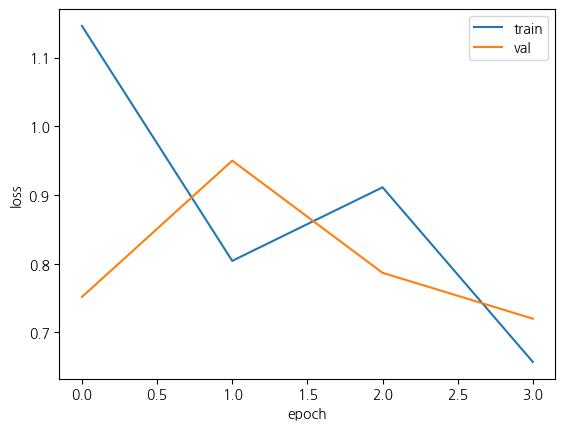

In [104]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

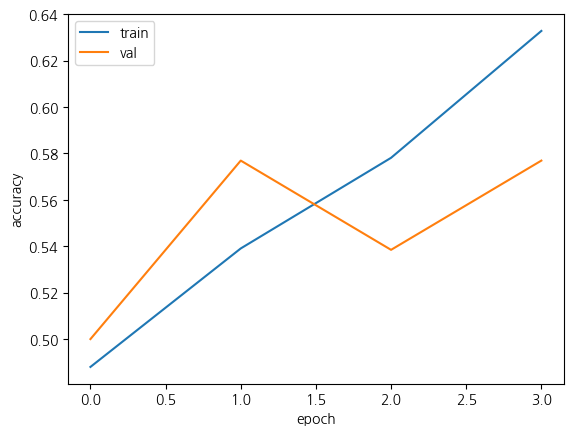

In [105]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

In [106]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [107]:
test_generator = test_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=400,
    shuffle=False,
    class_mode='categorical')

Found 20 images belonging to 2 classes.


In [108]:
model_final.evaluate(test_generator,verbose=0)

[0.6089876294136047, 0.75]

In [110]:
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[0.93703383 0.0629662 ]


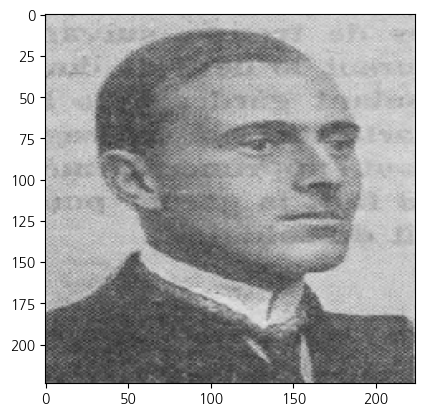

In [111]:
img_path = '../../../data/s_3/imgs/data_mw_test/man/ma_5.jpg'
# img_path = '/content/ss.JPG'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
plt.imshow(img_array/255)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = expanded_img_array / 255

prediction = model_final.predict(preprocessed_img)
print(np.array(prediction[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[0.34464195 0.6553581 ]


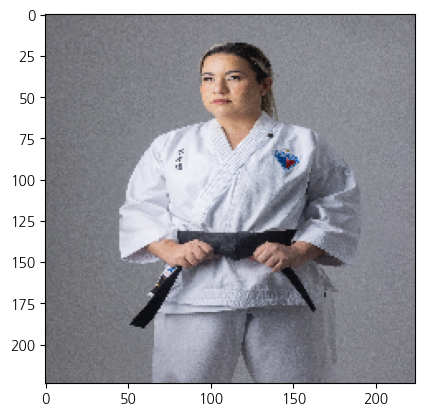

In [114]:
img_path = '../../../data/s_3/imgs/data_mw_test/woman/w_9.jpg'
# img_path = '/content/ss.JPG'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
plt.imshow(img_array/255)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = expanded_img_array / 255

prediction = model_final.predict(preprocessed_img)
print(np.array(prediction[0]))